# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

> You can compare two distributions with the Kullback-Leibler divergence, the Jensen-Shannon divergence or the Kolmogorov-Smirnov test amongst many others.

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

We do not know the density distribution and would need indirect ways of estimating the KL divergence. We also need to make sure that the location of the distributions are close as well: two distributions can have similar densities but might exist different locations/$\mu$. 

Additionally, not all measuring techniques perform well for different distribution shapes. When using a technique to compare distributions, a lot of assumptions need to be made.

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

If $N$ is large, the more complex the function becomes since it can learn more parameters as an input. This optimization process will likely take a long time and may create some kind of overfitting.
However, it must be large enough to make the output dimension greater than or equal to the input dimension. One of the dangers is that model can learn the identity function. 

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

If the distributions have no overlap, the JSD will be 0. Additionally, in this case, we can not use JSD.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

The model can reach [mode collapse](https://arxiv.org/pdf/1701.04862.pdf), a state where the generator gets stuck and doesnt converge to the global minimum but rather keeps reproducing within a local minimum. 

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [1]:
import numpy as np
import torch
import math
from sklearn import datasets

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

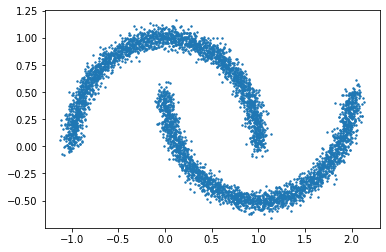

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [3]:
torch.normal(torch.zeros(10, 20), 1.0).shape

torch.Size([10, 20])

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(PRIOR_N, GEN_LAYERS),
            nn.ReLU(),
            nn.Linear(GEN_LAYERS, GEN_LAYERS),
            nn.ReLU(),
            nn.Linear(GEN_LAYERS, 2)
        )
        
    def __call__(self, z):
        return self.fc1(z)
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(2, DIS_LAYERS),
            nn.ReLU(),
            nn.Linear(DIS_LAYERS, DIS_LAYERS),
            nn.ReLU(),
            nn.Linear(DIS_LAYERS, 1)
        )    
    def __call__(self, x):
        return self.fc1(x)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


step 0: discriminator: 1.376e+00, generator: -6.270e-01


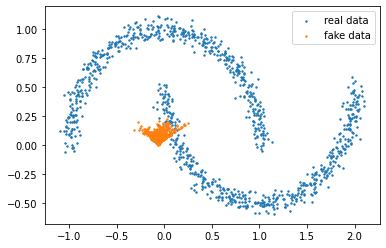

step 1000: discriminator: 1.386e+00, generator: -6.693e-01


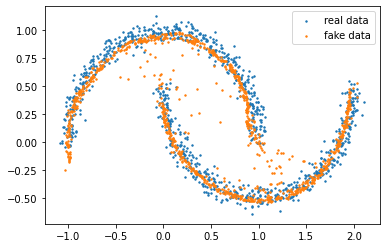

step 2000: discriminator: 1.382e+00, generator: -6.960e-01


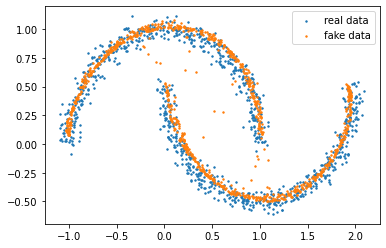

step 3000: discriminator: 1.391e+00, generator: -6.967e-01


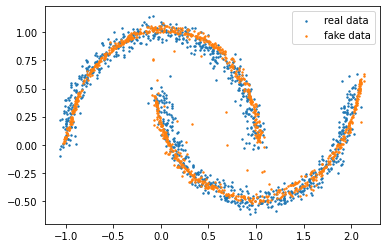

step 4000: discriminator: 1.391e+00, generator: -6.923e-01


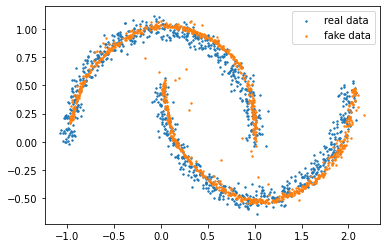

step 5000: discriminator: 1.386e+00, generator: -6.917e-01


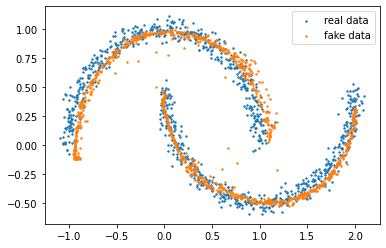

step 6000: discriminator: 1.387e+00, generator: -6.955e-01


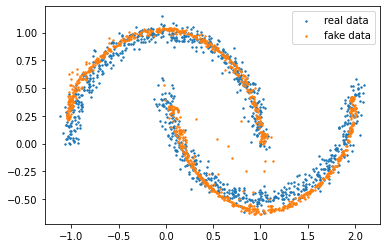

step 7000: discriminator: 1.387e+00, generator: -6.932e-01


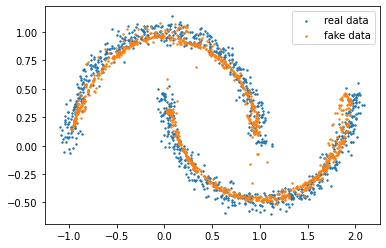

step 8000: discriminator: 1.386e+00, generator: -6.926e-01


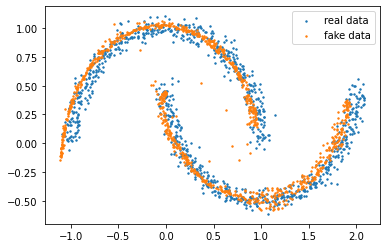

step 9000: discriminator: 1.385e+00, generator: -6.916e-01


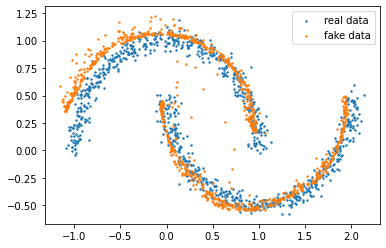

step 10000: discriminator: 1.388e+00, generator: -6.939e-01


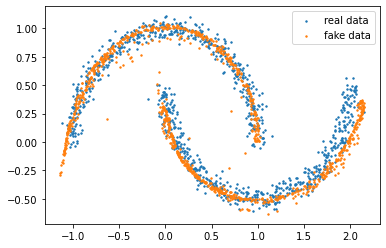

step 11000: discriminator: 1.385e+00, generator: -6.877e-01


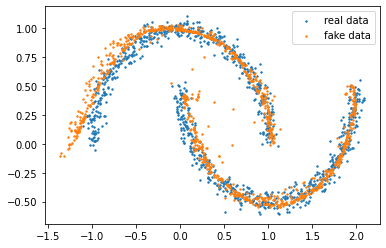

step 12000: discriminator: 1.388e+00, generator: -6.924e-01


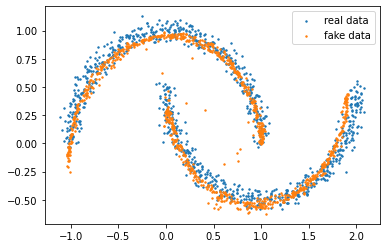

step 13000: discriminator: 1.387e+00, generator: -6.907e-01


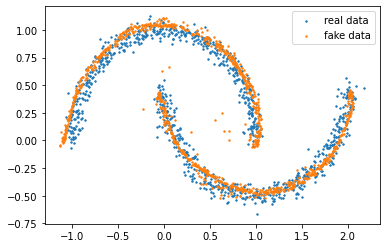

step 14000: discriminator: 1.386e+00, generator: -6.965e-01


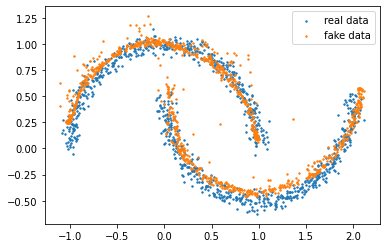

step 15000: discriminator: 1.384e+00, generator: -6.832e-01


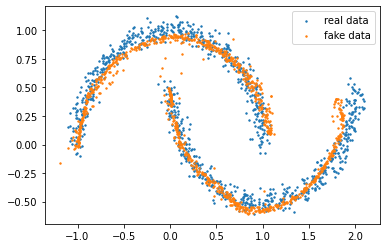

step 16000: discriminator: 1.382e+00, generator: -6.885e-01


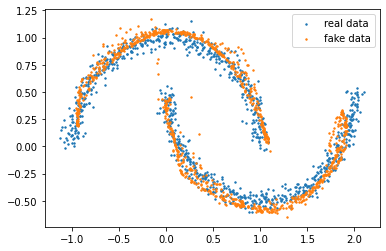

step 17000: discriminator: 1.385e+00, generator: -6.920e-01


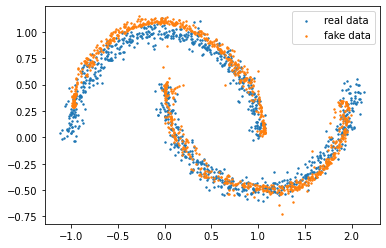

step 18000: discriminator: 1.388e+00, generator: -6.860e-01


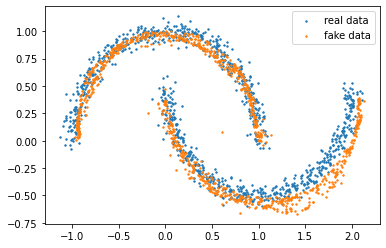

step 19000: discriminator: 1.388e+00, generator: -6.904e-01


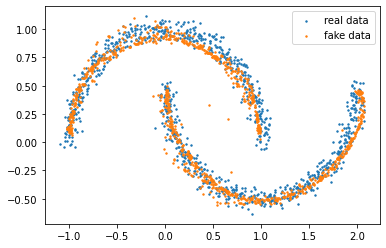

step 20000: discriminator: 1.383e+00, generator: -6.910e-01


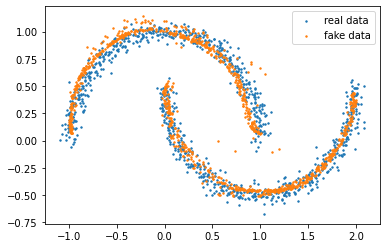

In [5]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 2
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

GEN_LAYERS = 128
DIS_LAYERS = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        output_disc_real = F.sigmoid(discriminator(real_batch))
        output_disc_fake = F.sigmoid(discriminator(fake_batch))
        disc_loss = torch.mean(-1.0*torch.log(output_disc_real))\
        + torch.mean(-1.0*torch.log(1.0-output_disc_fake))
        # END OF CODE
        disc_loss.backward()
        optim_disc.step()
#         disc_loss = 0
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    output_disc_fake = F.sigmoid(discriminator(fake_batch))
    gen_loss = torch.mean(torch.log(1.0-output_disc_fake))
    # END OF CODE
    gen_loss.backward()
    optim_gen.step()
#     gen_loss = 0

    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

the vanishing gradient causes this. If the discriminant has a small error where log(1)=0 this will cause training to get stuck

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

In [6]:
# IMPROVED VERSION

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 16)
        self.tanh = nn.Tanh()
        self.fc4 = nn.Linear(16, 2)
        
    def __call__(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.tanh(out)
        out = self.fc4(out)
        return out
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 64)
        self.fc3 = nn.Linear(64, 16)
        self.tanh = nn.Tanh()
        self.fc4 = nn.Linear(16, 1)
    
    def __call__(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.tanh(out)
        out = self.fc4(out)
        return out

step 0: discriminator: 1.369e+00, generator: 6.910e-01


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


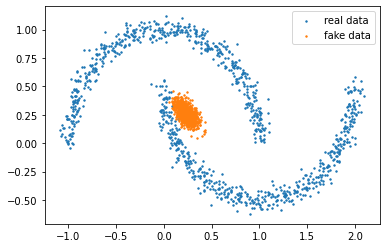

step 1000: discriminator: 1.384e+00, generator: 7.394e-01


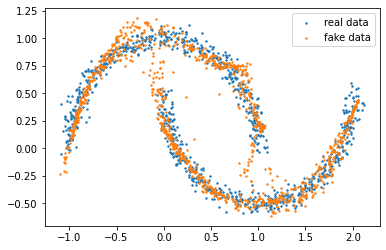

step 2000: discriminator: 1.384e+00, generator: 6.837e-01


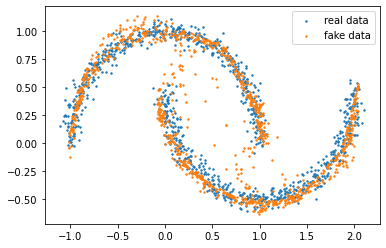

step 3000: discriminator: 1.381e+00, generator: 7.065e-01


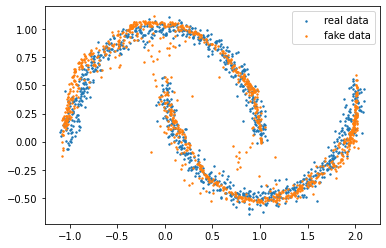

step 4000: discriminator: 1.397e+00, generator: 6.961e-01


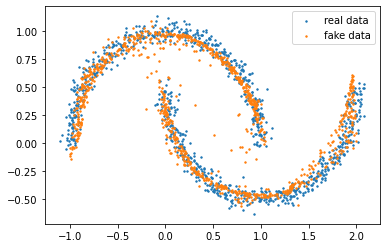

step 5000: discriminator: 1.376e+00, generator: 6.983e-01


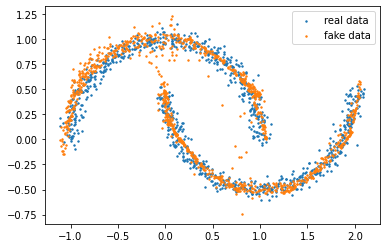

step 6000: discriminator: 1.400e+00, generator: 6.782e-01


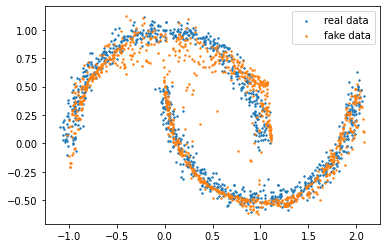

step 7000: discriminator: 1.364e+00, generator: 7.347e-01


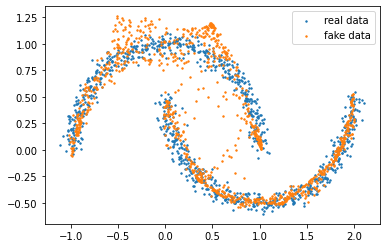

step 8000: discriminator: 1.387e+00, generator: 7.126e-01


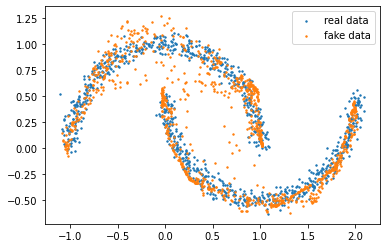

step 9000: discriminator: 1.386e+00, generator: 6.931e-01


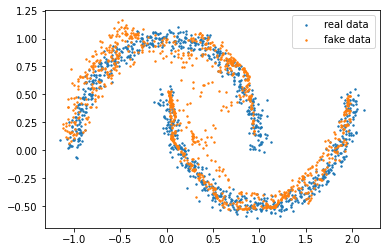

step 10000: discriminator: 1.388e+00, generator: 7.028e-01


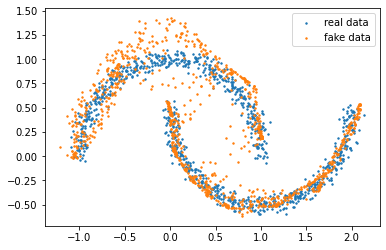

step 11000: discriminator: 1.384e+00, generator: 6.926e-01


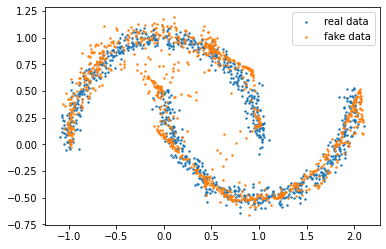

step 12000: discriminator: 1.385e+00, generator: 6.913e-01


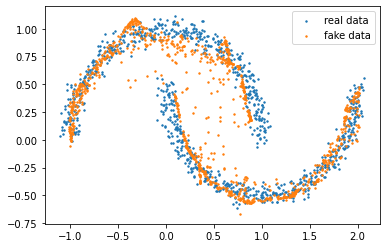

step 13000: discriminator: 1.385e+00, generator: 6.899e-01


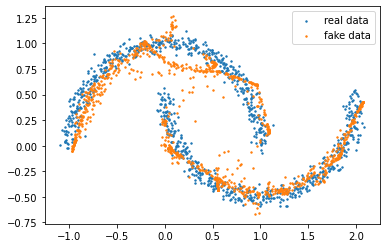

step 14000: discriminator: 1.384e+00, generator: 6.783e-01


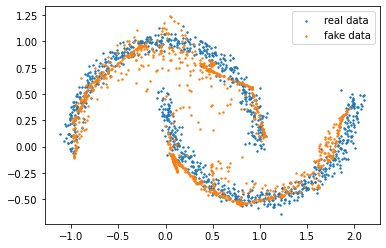

step 15000: discriminator: 1.387e+00, generator: 6.911e-01


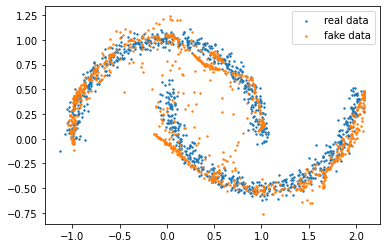

step 16000: discriminator: 1.386e+00, generator: 6.935e-01


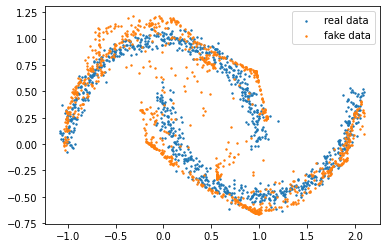

step 17000: discriminator: 1.387e+00, generator: 6.964e-01


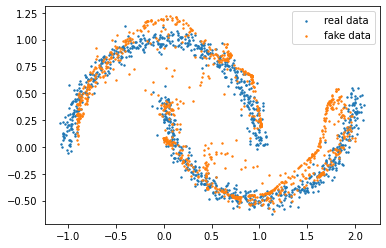

step 18000: discriminator: 1.387e+00, generator: 6.901e-01


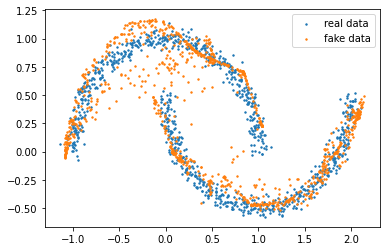

step 19000: discriminator: 1.388e+00, generator: 6.853e-01


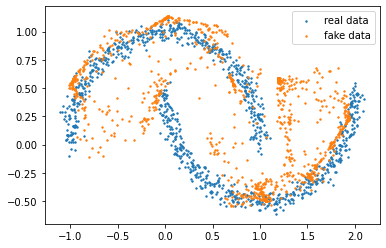

step 20000: discriminator: 1.370e+00, generator: 7.192e-01


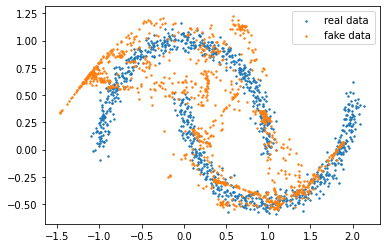

In [7]:
# IMPROVED VERSION
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 4
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

PRIOR_N = 20

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        output_disc_real = F.sigmoid(discriminator(real_batch))
        output_disc_fake = F.sigmoid(discriminator(fake_batch))
        disc_loss = torch.mean(-1.0*torch.log(output_disc_real))\
        + torch.mean(-1.0*torch.log(1.0-output_disc_fake))
        # END OF CODE
        # disc_loss = 0
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    output_disc_fake = F.sigmoid(discriminator(fake_batch))
    gen_loss = torch.mean(-torch.log(output_disc_fake))
    # END OF CODE
    # gen_loss = 0
    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

Increasing the depth and the width of both the generator and discriminator networks improves the speed at which the generator network experiences exploding gradients quite quickly and converges toward the real data. Furthermore, the generated data is more flexible and can take more different values in an attempt to imitate the true data.

Improving Train Ratio allows to converge faster but comes at the expense of taking longer to train.

For the discriminator, if it is too good in the early stages of training, gradient may explode. A high training ratio could make the discriminator too good for the generator.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**


$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D(x)}{p_\theta(x)}) \right] $$ 

$$ \iff D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(p_D(x)) - log({p_\theta}(x)) \right]$$

$$ \iff D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(p_D(x))\right] - \mathbb{E}_{p_D}\left[ log(p_{\theta} (x)) \right]$$


However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

If it samples from small variance distributions, then the encoder will not be able train on the regions of the decoder

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

$$D_{KL}(q_\phi(z | x) \| p(z))=\frac{1}{2}\left[ \left\lVert \mu_{\phi} \right\rVert_{2}^{2} + \sum \sigma^2_\phi -k -\log \left| \sum \sigma_\phi \right| \right]$$

Where $k$ in our case is 10. 

The full calculation can be found here
https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

We have $p_\theta (x\mid z) \sim \mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta(z))^\frac{1}{2})$. For our code, we can ignore the constants of a multivariate normal distribution and should use functions like sum instead of determinant or:

$- \log p_\theta (x\mid z) = - \log [\frac{1}{Sum(\sigma_\theta(z))^\frac{1}{2}} \times \exp(-\frac{1}{2} (\frac{x-\mu_\theta (z)}{Sum(\sigma_\theta(z))^\frac{1}{2}}))]$

$\iff - \log p_\theta (x\mid z) = - \log [\frac{1}{Sum(\sigma_\theta(z))^\frac{1}{2}}] + \log[\exp(-\frac{1}{2} (\frac{x-\mu_\theta (z)}{Sum(\sigma_\theta(z))^\frac{1}{2}}))]$

$\iff - \log p_\theta (x\mid z) = - \log [\frac{1}{Sum(\sigma_\theta(z))^\frac{1}{2}}] + \log[\exp(-\frac{1}{2} (\frac{x-\mu_\theta (z)}{Sum(\sigma_\theta(z))^\frac{1}{2}}))]$

$\iff - \log p_\theta (x\mid z) = - \log [\frac{1}{Sum(\sigma_\theta(z))^\frac{1}{2}}] -\frac{1}{2} (\frac{x-\mu_\theta (z)}{Sum(\sigma_\theta(z))^\frac{1}{2}})$

$\iff - \log p_\theta (x\mid z) = \log [{Sum(\sigma_\theta(z))^\frac{1}{2}}] -\frac{1}{2} (\frac{x-\mu_\theta (z)}{Sum(\sigma_\theta(z))^\frac{1}{2}})$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [8]:
# Choose a value for the latent dimension
LATENT_N = 10
# Choose a value for the latent dimension
INPUT_N = 2
INTERMEDIATE_N = 5
LATENT_N = 10

# Define the generator
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(INPUT_N, INTERMEDIATE_N)
        self.elu1 = nn.ELU()
        self.drop1 = nn.Dropout()
        self.fc2 = nn.Linear(INTERMEDIATE_N, LATENT_N)
        self.elu2 = nn.ELU()
        self.drop2 = nn.Dropout()
        self.fc_mu = nn.Linear(LATENT_N, LATENT_N)
        self.fc_logvar = nn.Linear(LATENT_N, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        next_input = self.drop1(self.elu1(self.fc1(x)))
        next_input = self.drop2(self.elu2(self.fc2(next_input)))
        mu = self.fc_mu(next_input)
        logvar = self.fc_logvar(next_input)
        return (mu, logvar)
    

# Define the discriminator
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(LATENT_N, LATENT_N)
        self.elu1 = nn.ELU()
        self.drop1 = nn.Dropout()
        self.fc2 = nn.Linear(LATENT_N, INTERMEDIATE_N)
        self.elu2 = nn.ELU()
        self.drop2 = nn.Dropout()
        self.fc_mu = nn.Linear(INTERMEDIATE_N, 2)
        self.fc_logvar = nn.Linear(INTERMEDIATE_N, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        next_input = self.drop1(self.elu1(self.fc1(z)))
        next_input = self.drop2(self.elu2(self.fc2(next_input)))
        mu = self.fc_mu(next_input)
        logvar = self.fc_logvar(next_input)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

step 0: KL: 9.955e-01, rec: 2.962e+00


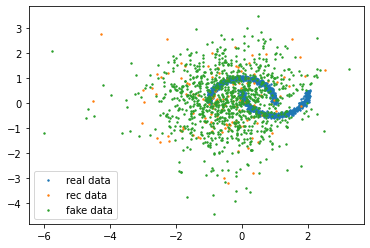

step 1000: KL: 1.947e-08, rec: 1.997e+00


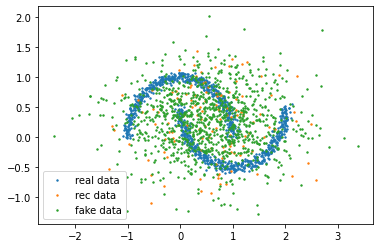

step 2000: KL: 1.572e-08, rec: 1.975e+00


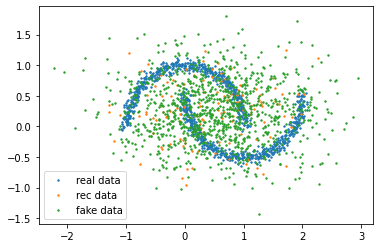

step 3000: KL: 1.806e-07, rec: 2.009e+00


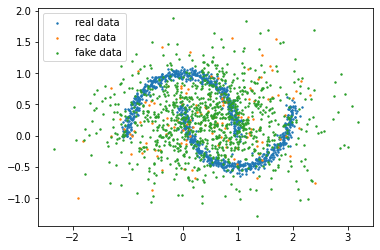

step 4000: KL: 5.963e-07, rec: 1.976e+00


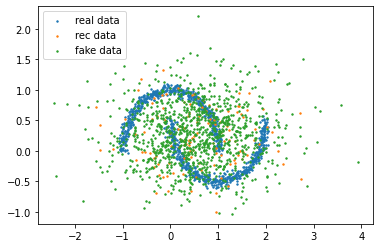

step 5000: KL: 9.126e-08, rec: 1.980e+00


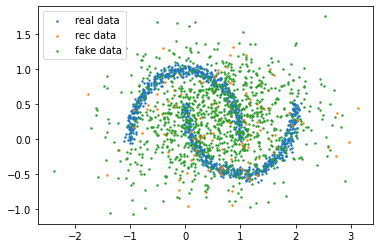

step 6000: KL: 1.130e-07, rec: 1.998e+00


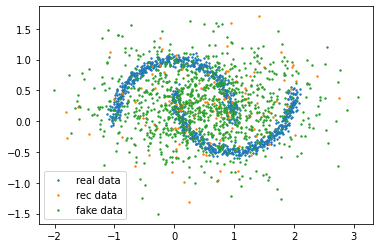

step 7000: KL: 4.148e-08, rec: 1.989e+00


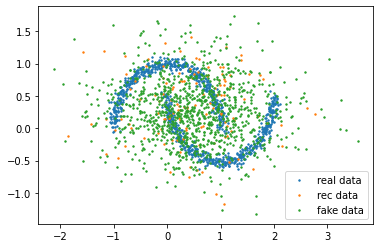

step 8000: KL: 1.040e-07, rec: 2.011e+00


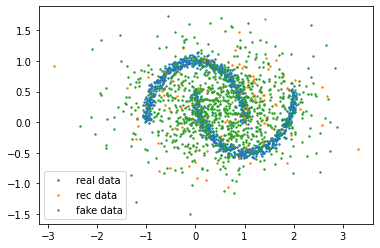

step 9000: KL: 8.829e-08, rec: 1.993e+00


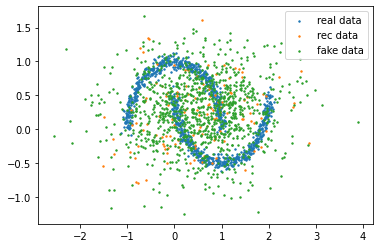

step 10000: KL: -6.497e-09, rec: 1.997e+00


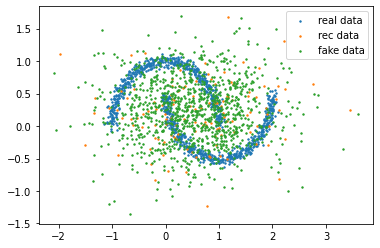

step 11000: KL: 2.785e-08, rec: 1.994e+00


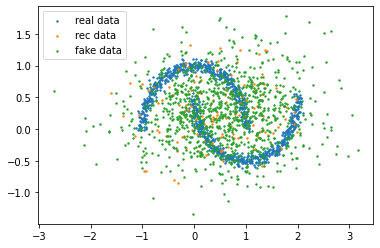

step 12000: KL: 4.128e-08, rec: 1.985e+00


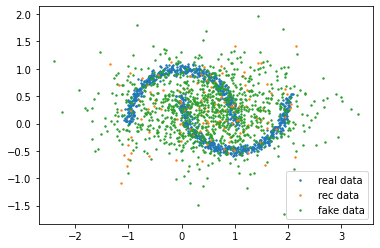

step 13000: KL: 6.144e-07, rec: 1.978e+00


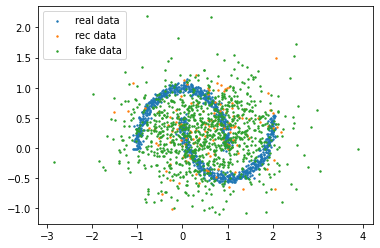

step 14000: KL: 1.669e-08, rec: 1.996e+00


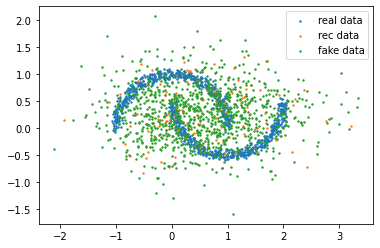

step 15000: KL: 5.407e-07, rec: 1.986e+00


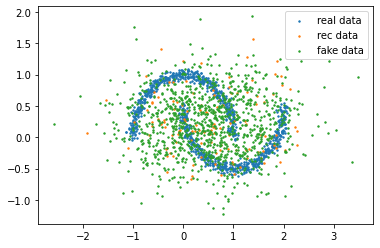

step 16000: KL: 1.676e-07, rec: 2.004e+00


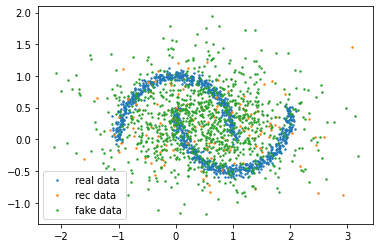

step 17000: KL: 1.249e-07, rec: 1.995e+00


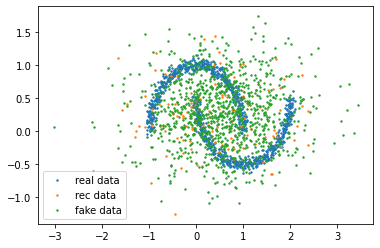

step 18000: KL: 4.560e-07, rec: 1.986e+00


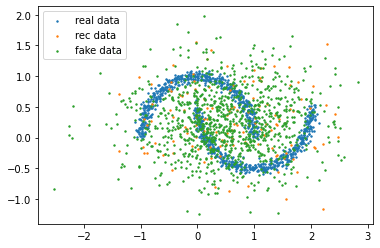

step 19000: KL: 1.570e-07, rec: 1.991e+00


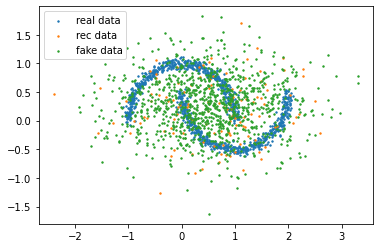

step 20000: KL: 9.915e-08, rec: 1.993e+00


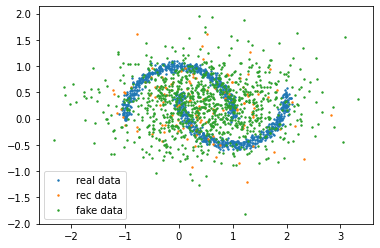

step 21000: KL: 5.284e-08, rec: 1.992e+00


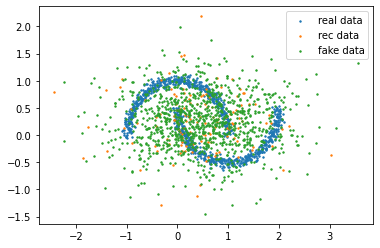

step 22000: KL: 2.394e-08, rec: 1.985e+00


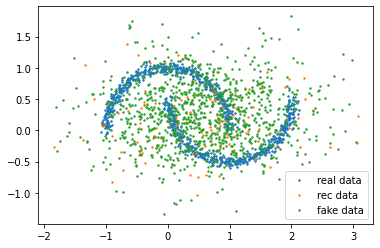

step 23000: KL: 7.957e-08, rec: 2.004e+00


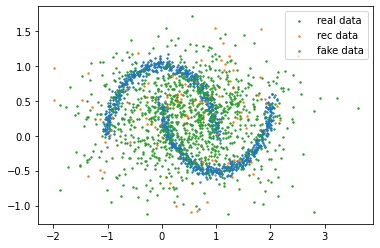

step 24000: KL: 6.249e-08, rec: 1.990e+00


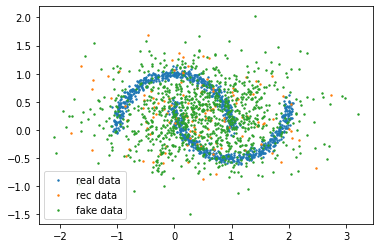

step 25000: KL: 1.072e-07, rec: 1.986e+00


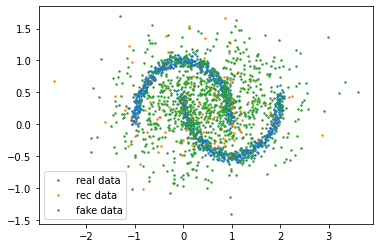

step 26000: KL: 7.669e-09, rec: 1.995e+00


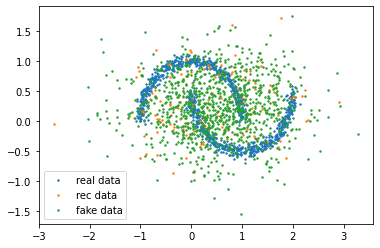

step 27000: KL: 6.488e-08, rec: 2.001e+00


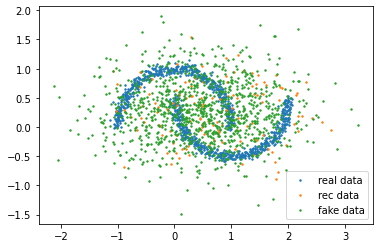

step 28000: KL: 4.473e-08, rec: 1.995e+00


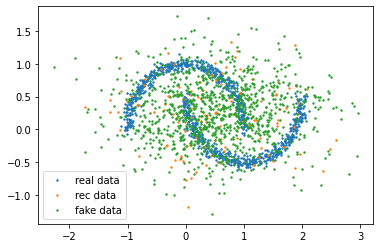

step 29000: KL: 4.291e-08, rec: 2.009e+00


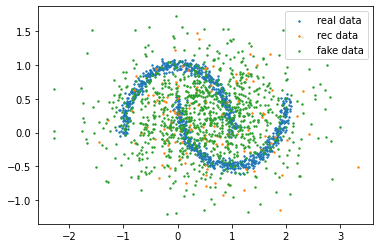

step 30000: KL: 5.040e-08, rec: 1.998e+00


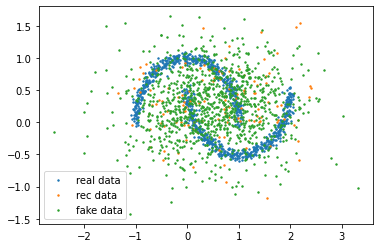

step 31000: KL: 3.595e-08, rec: 2.004e+00


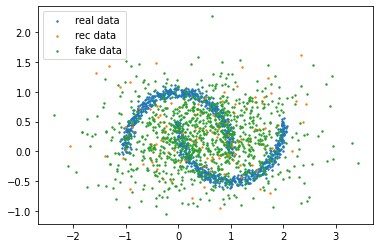

step 32000: KL: 1.718e-08, rec: 1.992e+00


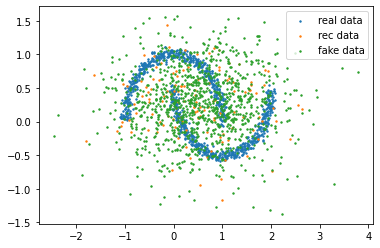

step 33000: KL: 6.205e-08, rec: 1.995e+00


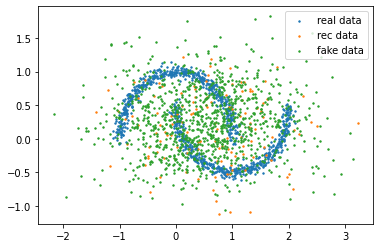

step 34000: KL: 2.992e-08, rec: 1.984e+00


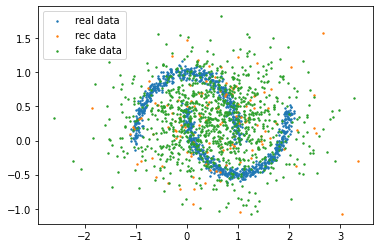

step 35000: KL: 5.139e-07, rec: 1.985e+00


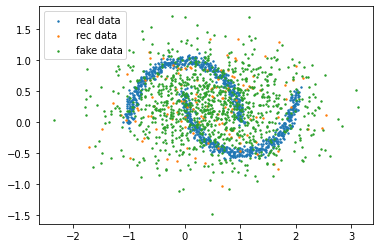

step 36000: KL: 5.858e-08, rec: 1.999e+00


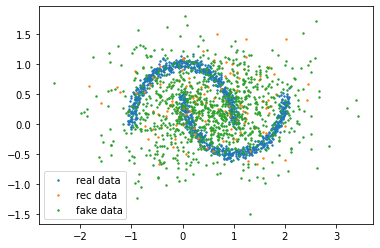

step 37000: KL: 3.999e-07, rec: 2.001e+00


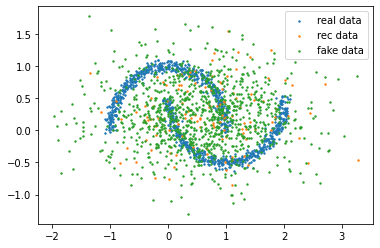

step 38000: KL: 5.156e-08, rec: 1.987e+00


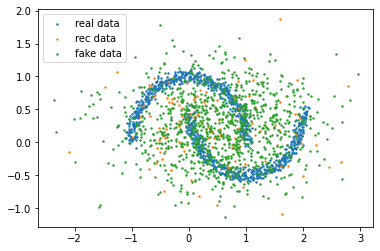

step 39000: KL: 4.556e-08, rec: 1.999e+00


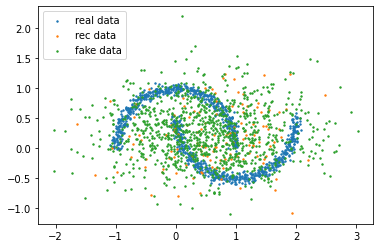

step 40000: KL: 1.183e-07, rec: 1.995e+00


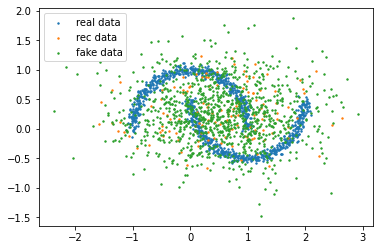

In [9]:
import random
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()
    
    x = generate_batch(BATCHLEN)
    
    enc_mu, enc_logvar = encoder(x)
    # enc_mu, enc_logvar = enc_mu.detach().numpy(), enc_logvar.detach().numpy()
    enc_sigma = torch.sqrt(torch.exp(enc_logvar))

    # SAMPLE z FROM q(z|x) HERE
    #
    z = torch.normal(enc_mu, enc_sigma) #, size=LATENT_N)
    dec_mu, dec_logvar = decoder(z)
    # dec_mu, dec_logvar = dec_mu.detach().numpy(), dec_logvar.detach().numpy()
    
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    enc_det = torch.sum(enc_logvar)
    eye = torch.eye(10, requires_grad=True)


    ##### ATTEMPT 1 ######
    # part1 = np.log(np.divide(enc_det, np.linalg.det(eye))) - LATENT_N
    # part2 = (0 - enc_mu).T
    # part3 = np.linalg.inv(np.cov(enc_logvar))
    # part4 = (0 - enc_mu) 
    # part5 = np.trace(np.linalg.inv(enc_sigma))
    # part6 = eye
    # loss_kl = 0.5* ( part1 +\
    #                 np.dot(np.dot(part2 , part3), part4) +\
    #                 np.dot(part5 , part6))
    ##### ATTEMPT 2 ######
    # part1 = torch.divide(torch.linalg.det(eye), enc_det) - LATENT_N
    # part2 = (enc_mu - 0).T
    # # part3 = torch.linalg.inv(eye)
    # part4 = (enc_mu - 0)

    # part3 = torch.sum(torch.square(enc_mu))
    # part5 = torch.sum(enc_sigma)
    # # # part6 = eye
    # # print(part1, "\n", 
    # #       part2.shape, part3.shape, part4.shape, "\n", 
    # #       part5, part6.shape)
    
    # print("part1: ", part1, "\n", 
    #       "part3: ", part3, "\n", 
    #       "part5: ", part5)
    
    # loss_kl = 0.5 * ( part1 +\
    #                 # ((part2 @ part3) @ part4) +\
    #                 part3 +\
    #                 # (part5 @ part6)
    #                 part5)

    # loss_kl = 0.5 * (torch.divide(torch.linalg.det(eye), enc_det) -\
    #                  LATENT_N +\
    #                  torch.sum(torch.square(enc_mu)) +\
    #                  torch.sum(enc_sigma))


    ##### ATTEMPT 3 ######
    enc_mu_new_t = torch.unsqueeze(enc_mu, dim=1)
    enc_mu_new = torch.unsqueeze(enc_mu, dim=2)

    loss_kl = 0.5 * torch.mean(
        torch.squeeze(enc_mu_new_t@enc_mu_new)\
        + torch.sum(torch.exp(enc_logvar), dim=1)\
        - LATENT_N\
        - torch.sum(enc_logvar, dim=1)
    )

    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    dec_sigma = torch.exp(dec_logvar)
    # xbar = torch.normal(dec_mu, dec_sigma) 
    
    # loss_rec = torch.sum(torch.sqrt(dec_sigma)) +\
    #           0.5 * ( (enc_mu - dec_mu).T @ torch.linalg.inv(enc_sigma) @ (enc_mu - dec_mu) +\
    #                  torch.sum(torch.linalg.inv(dec_sigma) @ enc_sigma) )

    loss_rec = 0.5 * torch.mean(
        INPUT_N * np.log(2 * np.pi)\
        + torch.sum(dec_logvar, dim=1)\
        + torch.sum(torch.square(x-dec_mu) / torch.exp(dec_logvar), dim=1)
    )

    (loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

The data becomes dense and closely centered around the $\mu$ (which in this case is two dimensional)


**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

If we increase the power of the encoder, it will create a $z$ that is closer and closer to the standard normal distribution which we had set as the priori target. 

Increasing the power of the decoder will generate data closer to that of the input's distribution. 

### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

We have:

$$x = f_{-1}(z)$$

$$\iff p_Z(z) \times \frac{df(x)}{dx} = p_X(x)$$

$$\iff log(p_Z(z) \times det J_f) = log(p_X(x))$$

$$\iff log(p_X(x)) = log(p_Z(z)) + log(det J_f)$$

Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

Given: $D_{K L}\left(P_{\theta} \| P_{D}\right)=\int_{x} P_{\theta}(x) \log \frac{P_{\theta}(x)}{P_{D}(x)} d x$

$$KL(p_D \mid \mid p_G) = \mathbb{E}_{p_D} [\log(\frac{p_D}{p_G})]$$

$$\iff KL(p_D \mid \mid p_G) = \mathbb{E}_{p_D} [\log(p_D) - \log (p_G)]$$

$$\iff KL(p_D \mid \mid p_G) = \mathbb{E}_{p_D} [\log(p_X(x)) - \log (p_Z(z))]$$

$$\iff KL(p_D \mid \mid p_G) = \mathbb{E}_{p_D} [\log (p_Z(z)) + \log(det J_f) - \log (p_Z(z))]$$ simplifying:
$$\iff KL(p_D \mid \mid p_G) = \mathbb{E}_{p_D} [\log(det J_f)]$$

$$\iff KL(p_D \mid \mid p_G) = \log(det J_f) $$


A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

its ok i will take the point off here

**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

hope u had a good day

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [10]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        ### define here variables to use in f and s ###
        self.s_layer = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size,output_size),
            nn.Tanh()
            )
        self.t_layer = nn.Sequential(
            nn.Linear(input_size,hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size,output_size)
            )
        
        ###
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        return self.s_layer(x_m)
        
    def tfun(self, x_m):
        return self.t_layer(x_m)
        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        y_m = y * self.mask
        s_out = self.sfun(y_m)
        t_out = self.tfun(y_m)
        y = y_m + (1-self.mask)*torch.div(y-t_out,torch.exp(s_out))
        return y

In [11]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [12]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [13]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [14]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [15]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.017722
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.041595
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.050239
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.053978
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.055258
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.055461
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.056759
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.054790
====> Epoch: 1 Average train loss: -0.0491


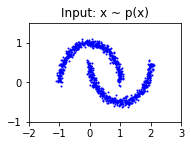

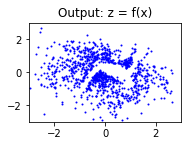

====> Test loss: -0.0580


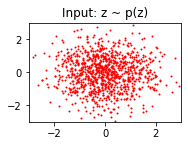

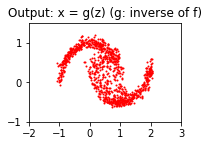

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.057166
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.056018
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.057731
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.056817
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.058041
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.057395
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.055601
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.058571
====> Epoch: 2 Average train loss: -0.0574


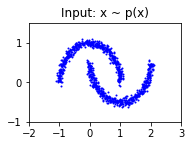

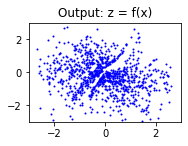

====> Test loss: -0.0595


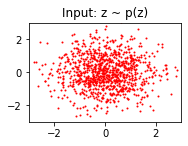

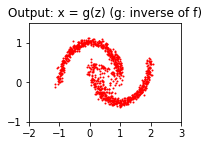

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.058040
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.058189
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.058088
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.059893
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.058621
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.059328
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.060273
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.058732
====> Epoch: 3 Average train loss: -0.0588


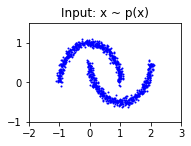

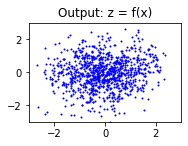

====> Test loss: -0.0606


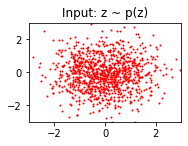

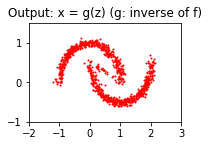

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.059435
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.059313
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.058496
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.059555
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.059429
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.059552
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.059359
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.059996
====> Epoch: 4 Average train loss: -0.0594


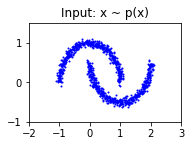

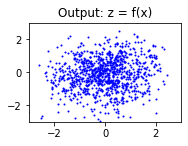

====> Test loss: -0.0608


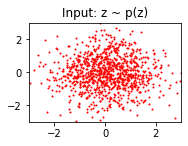

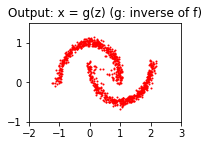

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.059331
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.059075
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.060176
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.059440
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.058391
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.059462
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.059751
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.058718
====> Epoch: 5 Average train loss: -0.0595


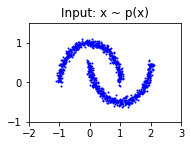

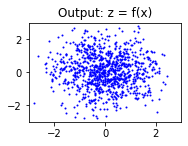

====> Test loss: -0.0609


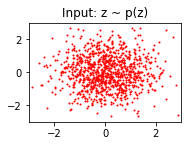

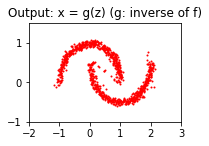

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.059852
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.059742
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.059265
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.059531
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.060011
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.059827
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.058298
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.058653
====> Epoch: 6 Average train loss: -0.0596


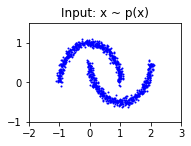

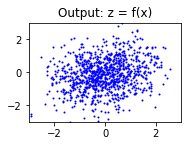

====> Test loss: -0.0608


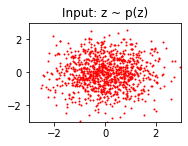

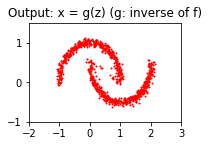

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.059663
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.059531
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.059422
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.059787
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.059405
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.059476
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.059143
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.058819
====> Epoch: 7 Average train loss: -0.0596


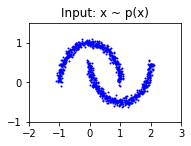

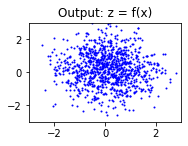

====> Test loss: -0.0608


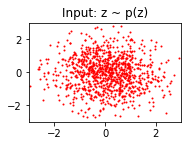

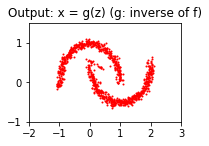

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.059667
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.060715
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.059992
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.059644
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.059893
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.060202
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.060279
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.058634
====> Epoch: 8 Average train loss: -0.0596


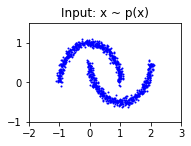

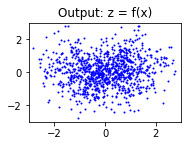

====> Test loss: -0.0608


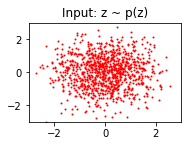

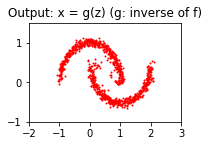

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.058989
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.060096
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.060218
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.059958
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.059739
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.059522
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.059849
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.059494
====> Epoch: 9 Average train loss: -0.0597


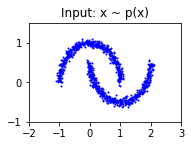

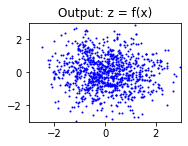

====> Test loss: -0.0609


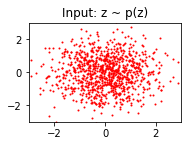

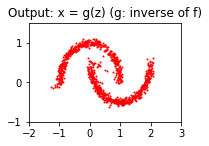

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.060019
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.059712
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.059399
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.060553
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.060393
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.059991
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.059368
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.059880
====> Epoch: 10 Average train loss: -0.0597


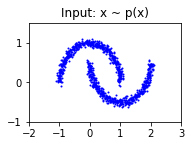

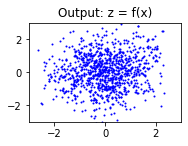

====> Test loss: -0.0609


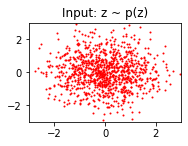

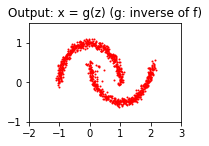

'151.75s'

<Figure size 432x288 with 0 Axes>

In [16]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

requires assumptions: invertible and differentiable with a tractable determinant.
Furthermore, $f^{-1}$ often has trouble mapping smooth distributions since its hard to find the discrete moment where clusters differentiate themselves. 

**Q20: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows?**

VAE has the benefit of being able to draw from a greater proportion of the input space, however the output space may be far from the real distribution. Additionally, it may learn the identity function. 

GANs can be very precise, and have the benefit of being generalizable since they do not make any assumption on the distribution of real data. However it requires fine-tuning and requires an intricate balance to avoid vanishing gradient and mode collapse.

Normalizing flows in this case converged the best, but has serious limitations. It can take significantly longer to train compared to the other methods and often need a high dimensional latent space, as well as invertible functions whose gradients are feasibly computable. 